In [1]:
!pip3 install opencv-python
!pip3 install matplotlib 
!pip3 install sklearn

In [2]:
import cv2
from matplotlib import pyplot as plt 
import numpy as np
import math

In [3]:
def fix_image_to_show(img):
    image = img.copy()
    image = image.astype('float32')
    max_pixel = np.max(image)
    min_pixel = np.min(image)
    if max_pixel == min_pixel:
        image[:, :, :] = 127
        image = image.astype('uint8')
        return image
    m = 255 / (max_pixel - min_pixel)
    image = image * m - min_pixel * m
    image = image.astype('uint8')
    return image

def show_image(img, name=None, cmap=None):
    image = img.copy()
    image = fix_image_to_show(image)
    plt.imshow(image, vmin=0, vmax=255, cmap=cmap)
    plt.show()
    if name is not None :
        plt.imsave(name + '.jpg', image, cmap=cmap)

In [4]:
def train_data(win_size=(128, 128), block_size=(16, 16), block_stride=(8, 8), cell_size=(8, 8), nbins=9, svm_kernel='linear', prob=False, L2HysThreshold=0.2): 
    def read_directory_images(directory):
        images = []
        import os
        files = os.listdir(directory)
        #     win_size = (64, 64)
        #     block_size = (16, 16)
        #     block_stride = (8, 8)
        #     cell_size = (8, 8)
        #     nbins = 9
        print("start reading images")
        hog = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, nbins)
        for file in files: 
            path = directory + '/' + file 
            image_names = os.listdir(path)
            for image_name in image_names: 
                if image_name[-3:] != 'jpg':
                    continue
                image = cv2.imread(path + '/' + image_name)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, win_size)

                feature_vector = hog.compute(image)
                feature_vector = feature_vector.reshape((feature_vector.shape[0],))
                images.append(feature_vector)
                if len(images) > 13000:
                    return images

        return images
    
    positive_images = read_directory_images('resources/lfw')
    negative_images = read_directory_images('resources/256_ObjectCategories')
    
    # import random
    # random.shuffle(positive_images)
    # random.shuffle(negative_images)

    negative_images = negative_images[0: len(positive_images)]

    train_positive = positive_images[0: 10000].copy()
    validation_positive = positive_images[10000: 11000].copy()
    test_positive = positive_images[11000: 12000].copy()

    train_negative = negative_images[0: 10000].copy()
    validation_negative = negative_images[10000: 11000].copy()
    test_negative = negative_images[11000: 12000].copy()

    class_positive = ['positive' for i in range(10000)]
    class_negative = ['negative' for i in range(10000)]

    train_dataset = train_positive + train_negative
    train_class_name = class_positive + class_negative

    test_dataset = test_positive + test_negative

    class_positive = ['positive' for i in range(1000)]
    class_negative = ['negative' for i in range(1000)]
    test_class_name = class_positive + class_negative
    
    validation_dataset = validation_positive + validation_negative 
    validation_class_name = test_class_name.copy()
    
    from sklearn.pipeline import make_pipeline
    from sklearn.preprocessing import StandardScaler

    X = train_dataset.copy()
    Y = train_class_name.copy()

    from sklearn.svm import SVC
    clf = make_pipeline(StandardScaler(), SVC(gamma='auto', kernel=svm_kernel, probability=prob))
    print("start training data")
    clf.fit(X, Y)
    print('end training data')
    
    return clf, validation_dataset, validation_class_name, test_dataset, test_class_name

In [5]:
def validate_data(clf, validation_dataset, validation_class_name):
    cnt = 0
    for i in range(len(validation_dataset)):
        test_vector = validation_dataset[i]
        predict = clf.predict(test_vector.reshape(1, -1))[0]
        if predict == validation_class_name[i]:
            cnt = cnt + 1

    return (cnt / len(validation_dataset)) * 100

In [6]:
def test_data(clf, test_dataset, test_class_name): 
    cnt = 0
    for i in range(len(test_dataset)):
        test_vector = test_dataset[i]
        predict = clf.predict(test_vector.reshape(1, -1))[0]
        if predict == test_class_name[i]:
            cnt = cnt + 1

    return (cnt / len(test_dataset)) * 100

In [7]:
win_size = 128
best_cell_size = 16
best_block_size = 32 
best_block_stride = 16
best_nbins = 8
best_svm_kernel = 'rbf'
best_validation_result = 0

In [ ]:
#TODO fix best_win_size
for win_size_l in range(64, 156, 32):
    for cell_size in range(6, 11): 
        for block_size in range(12, 21): 
            block_stride = int(block_size / 2)
            if ((win_size_l - block_size) % block_stride != 0):
                continue
            if (block_size % cell_size) != 0: 
                continue
            for nbins in range(6, 13, 3):
                for svm_kernel in ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']: 
                    clf, validation_dataset, validation_class_name, test_dataset, test_class_name = train_data((win_size_l, win_size_l), (block_size, block_size), 
                                                                                                              (block_stride, block_stride), (cell_size, cell_size), nbins, svm_kernel)

                    print("start running validation data", cell_size, block_size, block_stride, nbins, svm_kernel)
                    validation_result = validate_data(clf, validation_dataset, validation_class_name)
                    print("done validation data with:", validation_result)

                    if best_validation_result < validation_result: 
                        win_size = win_size_l
                        best_validation_result = validation_result
                        best_cell_size = cell_size
                        best_block_size = block_size
                        best_block_stride = block_stride
                        best_nbins = nbins
                        best_svm_kernel = svm_kernel

            

In [9]:
#these are the best values 
#you don't need to run this cell if if you trained your data
win_size = 128
best_cell_size = 16
best_block_size = 32
best_block_stride = 16
best_nbins = 8
best_svm_kernel = 'rbf'

In [10]:
clf, validation_dataset, validation_class_name, test_dataset, test_class_name = train_data((win_size, win_size), (best_block_size, best_block_size), 
                                                                                                          (best_block_stride, best_block_stride), 
                                                                                           (best_cell_size, best_cell_size), best_nbins, best_svm_kernel, True)

print(test_data(clf, test_dataset, test_class_name))

start reading images
start reading images
start training data
end training data
99.85000000000001


No handles with labels found to put in legend.


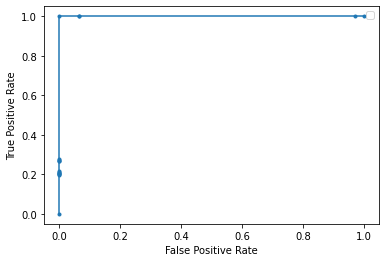

In [11]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

probs = clf.predict_proba(test_dataset)
probs_f = probs[:, 1]
test_class = [int(i < 1000) for i in range(2000)]
roc_score = roc_auc_score(test_class, probs_f)
fpr, tpr, _ = roc_curve(test_class, probs_f)
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.savefig('res1.jpg')

No handles with labels found to put in legend.


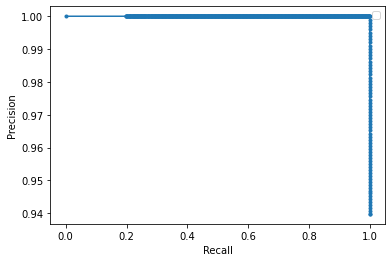

In [12]:
from sklearn.metrics import precision_recall_curve
precision, recall, _ = precision_recall_curve(test_class, probs_f)
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.savefig('res2.jpg')

In [13]:
from sklearn.metrics import average_precision_score
print('AP is :', average_precision_score(test_class, probs_f))

AP is : 0.9999398496240601


In [14]:
def add_padding_to_image(image, pix): 
    result = np.zeros((image.shape[0] + pix, image.shape[1] + pix, 3), dtype='uint8')
    pix = int(pix / 2)
    for i in range(pix, pix + image.shape[0]):
        for j in range(pix, pix + image.shape[1]):
            result[i, j] = image[i - pix, j - pix]
    return result

In [15]:
def find_boxes(image, clf, win_size, block_size, block_stride, cell_size, nbins):
    img = image.copy()
    hog = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, nbins)
    z = 1
    boxes_list = []
    scores_list = []
    for tc in range(6):
        if tc != 0:
            image = cv2.resize(image, (0, 0), fx=0.8, fy=0.8)
            z *= (1 / 0.8)
        image = cv2.GaussianBlur(image, (3, 3), 0)
        for i in range(0, image.shape[0] - win_size[0] + 1, 8): 
            for j in range(0, image.shape[1] - win_size[1] + 1, 8):
                window = image[i: i + win_size[0], j: j + win_size[1], :]
                feature_vector = hog.compute(window)
                feature_vector = feature_vector.reshape((feature_vector.shape[0],))
                predict = clf.predict(feature_vector.reshape(1, -1))
                if predict[0] == 'positive':
                    pt1 = (int(j * z), int(i * z))
                    pt2 = (int((j + win_size[0]) * z), int((i + win_size[1]) * z))
                    img = cv2.rectangle(img, pt1, pt2, color=(255, 0, 0), thickness=5)
                    boxes_list.append([pt1[0], pt1[1], pt2[0], pt2[1]])
        
    
    
    return img, boxes_list, scores_list
    
def faceDetector(image):
    global clf, win_size, best_block_size, best_block_stride, best_cell_size, best_nbins
        
    img, boxes_list, scores_list = find_boxes(image, clf, (win_size, win_size), (best_block_size, best_block_size)
                                              , (best_block_stride, best_block_stride), (best_cell_size, best_cell_size), best_nbins)
    
    #nms
    boxes, boxes_weight = cv2.groupRectangles(boxes_list, 1, eps=0.1)
    
    res_image = image.copy()
    for i in range(len(boxes)):
        box = boxes[i]
        box_weight = boxes_weight[i]
        if box_weight < 7:
            continue
    #     pt1 = (boxes_list[box][0], boxes_list[box][1])
    #     pt2 = (boxes_list[box][2], boxes_list[box][3])
        pt1 = (box[0], box[1])
        pt2 = (box[2], box[3])
        res_image = cv2.rectangle(res_image, pt1, pt2, color=(0, 0, 255), thickness=5)
    return res_image
    

def face_finder(directory, save_name): 
    image = cv2.imread(directory)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = add_padding_to_image(image, 100) 
    #print(win_size, block_size, block_stride, cell_size, nbins)
    res_image = faceDetector(image)
    
    show_image(res_image, save_name)
    


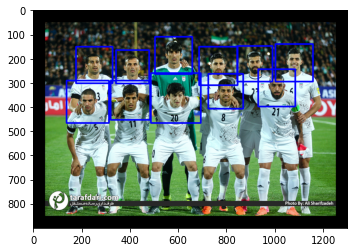

In [16]:
face_finder('resources/Melli.jpg', 'res4')

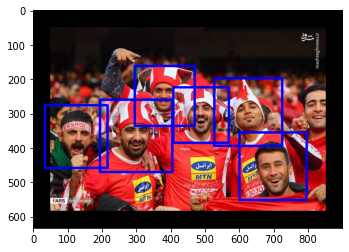

In [17]:
face_finder('resources/Persepolis.jpg', 'res5')

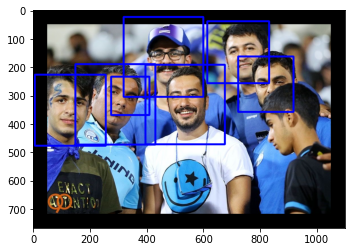

In [18]:
face_finder('resources/Esteghlal.jpg', 'res6')